## Importing relevant libraries

In [293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from pandas.api.types import is_string_dtype, is_numeric_dtype

import math
from sklearn.preprocessing import LabelEncoder, StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

%matplotlib inline

import warnings
warnings.simplefilter("ignore")

## Importing the dataset

In [74]:
data = pd.read_csv("train.csv")
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Data Structure and Content

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [5]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [6]:
data.describe(include=[object])

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,8523,6113,8523,8523
unique,1559,5,16,10,3,3,4
top,FDW13,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,10,5089,1232,935,2793,3350,5577


The data consists of 8523 observations and 12 features that can be divided into numerical and categorical:
* **Numerical:**
    * **Item_Weight:** Weight of the product.
    * **Item_Visibility:** The % of the total display area of all products in a store allocated to the particular product.
    * **Item_MRP:** Maximum Retail Price of the product.
    * **Outlet_Establishment_Year:** Year in which the store was stablished.
    * **Item_Outlet_Sales:** Sales of the product in that particular store. Target variable.
* **Categorical:**
    * **Item_Identifier:** Unique product ID.
    * **Item_Fat_Content:** Identifies each product as `Regular` or `Low Fat`.
    * **Item_Type:** Category of the product
    * **Outlet_Identifier:** Unique store ID
    * **Outlet_Size:** Size of the store.
    * **Outlet_Location_Type:** Type of the city in which the store is located.
    * **Outlet_Type:** Classifies the sotre as grocery store or three levels of supermarkets. 

In [7]:
data.isnull().sum().sort_values(ascending=False)

Outlet_Size                  2410
Item_Weight                  1463
Item_Identifier                 0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

There are also null values that will be imputed.

## Exploratory Data Analysis (EDA)

In [59]:
# Populate the lists of categorical and numerical variables
num_list = []
cat_list = []

for column in data:
    if (is_numeric_dtype(data[column])):
        num_list.append(column)
    else:
        cat_list.append(column)

print("Numeric columns:", num_list)
print("Categorical columns:", cat_list)

Numeric columns: ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']
Categorical columns: ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


I'm going to remove the **Item_Identifier** column from the categorical list, since it contains too many different values for exploring its content:

In [60]:
cat_list.remove('Item_Identifier')

In [38]:
columns_to_plot = data.columns.values.tolist()
columns_to_plot.remove('Item_Identifier')

### Univariate analysis
I will plot each variable on its own to see its distribution.

#### Numerical variables

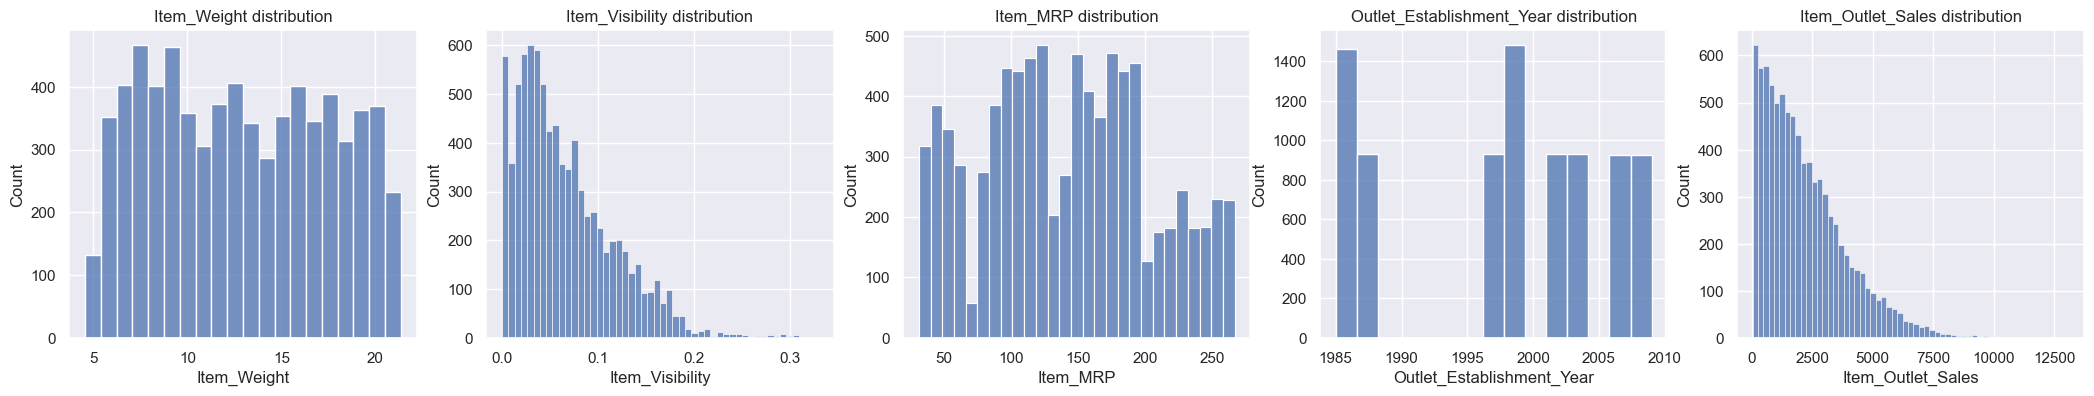

In [44]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26, 4))

for index, col in enumerate(num_list):
    sns.histplot(data[col], kde=False, ax=ax[index])
    ax[index].set_title(f'{col} distribution')

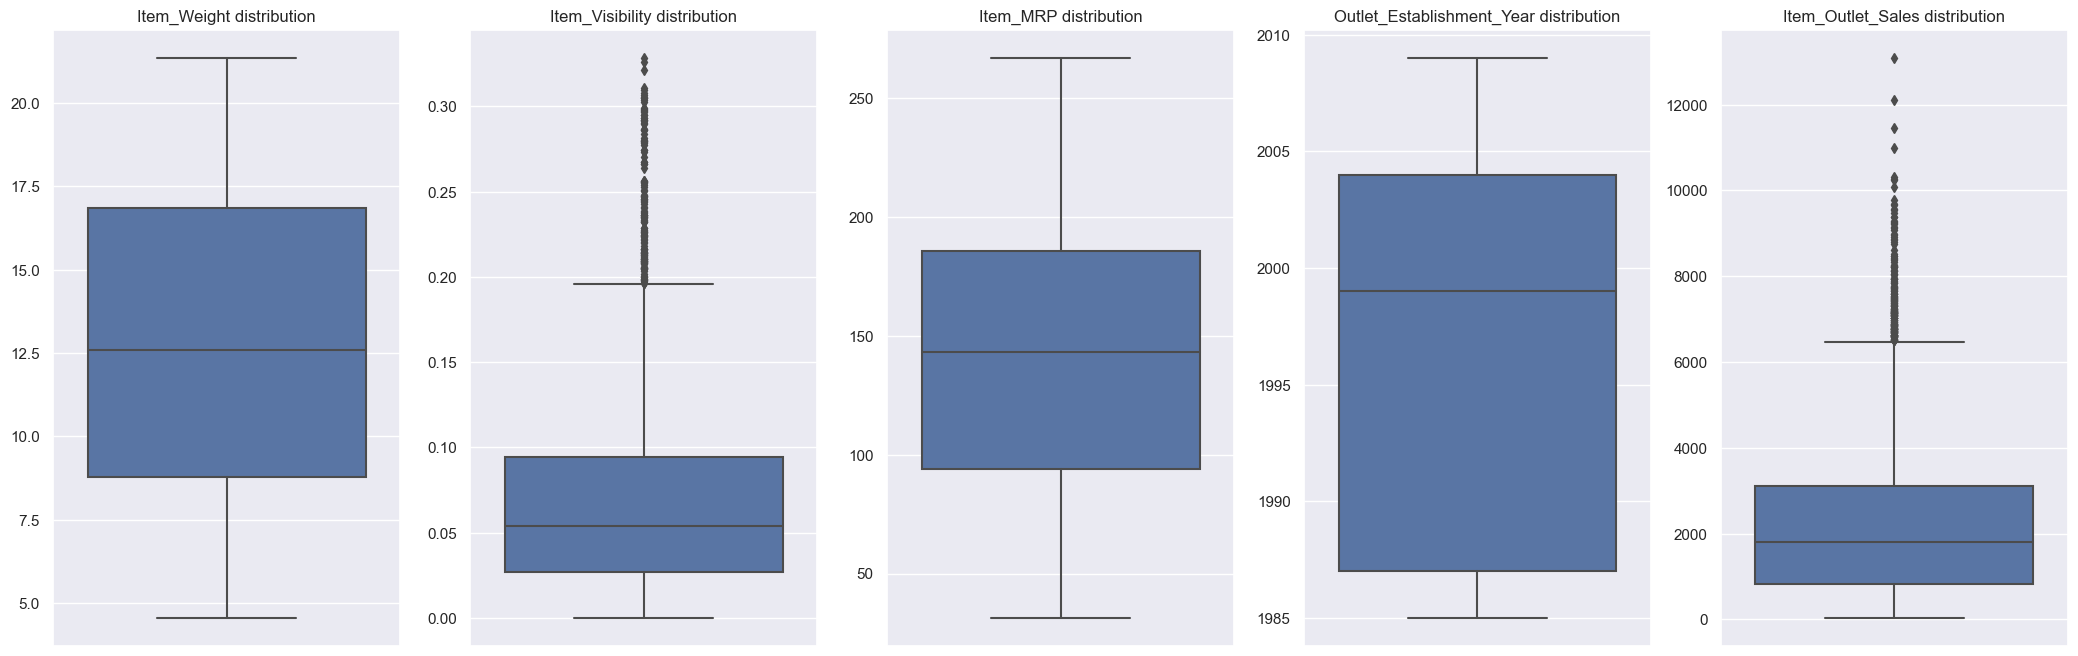

In [47]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26,8))

for index, col in enumerate(num_list):
    sns.boxplot(data=data, y=col, ax=ax[index])
    ax[index].set_title(f'{col} distribution')
    ax[index].set_ylabel('')

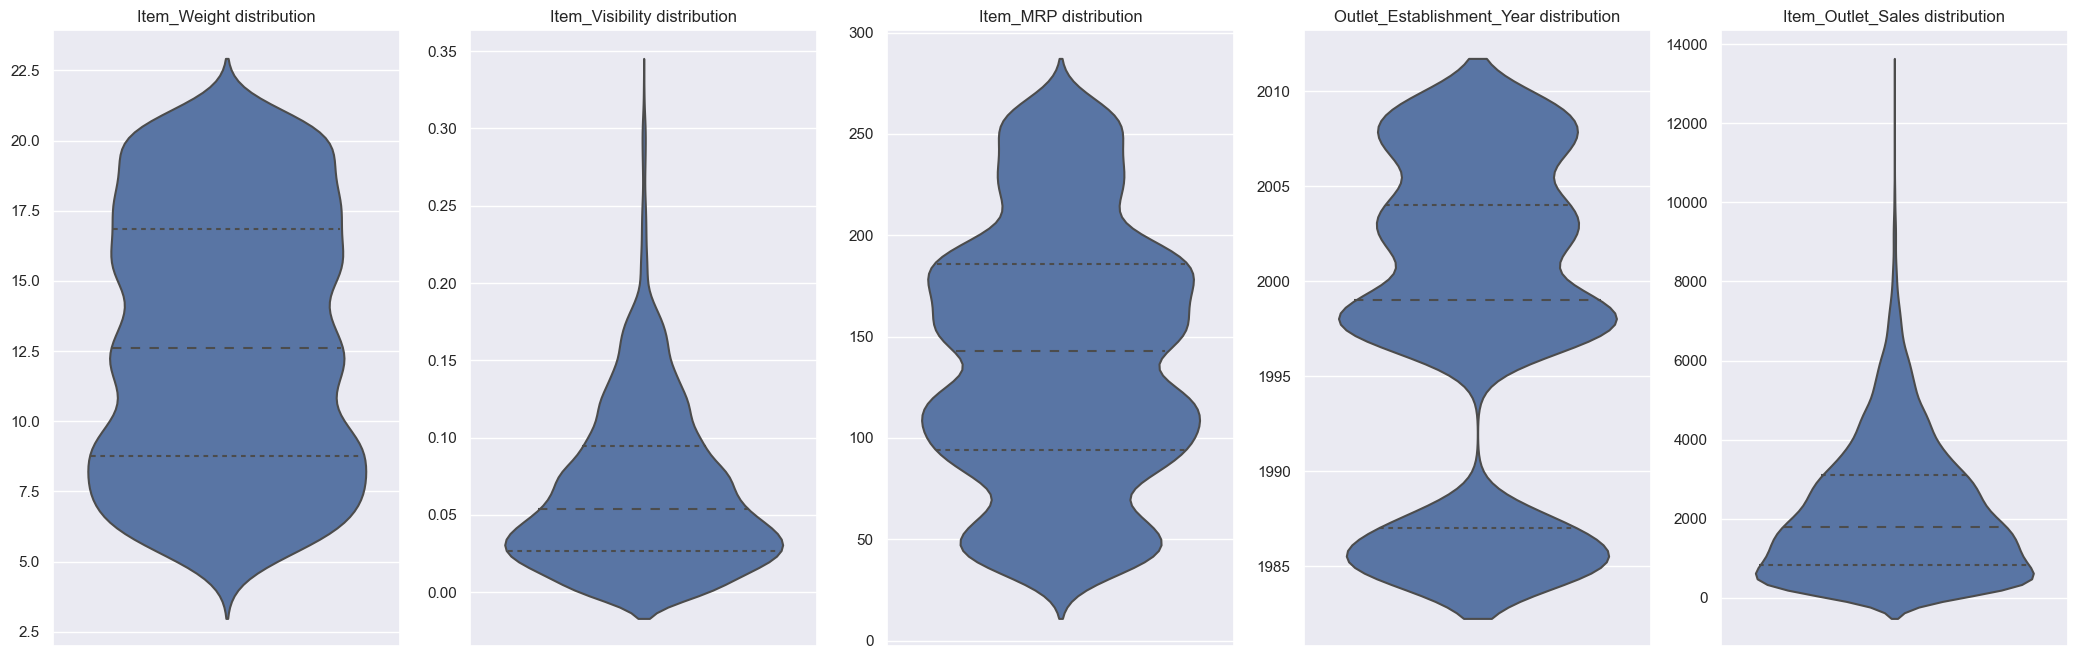

In [48]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26,8))
for index, col in enumerate(num_list):
    sns.violinplot(data=data, y=col, ax=ax[index], inner='quartile')
    ax[index].set_title(f'{col} distribution')
    ax[index].set_ylabel('')

Based on the plots, we can stablish the following:
* **Item_Weight** is uniformly distributed.
* **Item_Visibility** and **Item_Outlet_Sales** are right skewed and present outliers.
* **Item_MRP** The majority of the products are ranged between 80 and 180.

#### Categorical variables

In [61]:
for col in cat_list:
    print(f"Number of values in the {col} column is:\n{data[col].value_counts() }")
    print("--" * 30)

Number of values in the Item_Fat_Content column is:
Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64
------------------------------------------------------------
Number of values in the Item_Type column is:
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64
------------------------------------------------------------
Number of values in the Outlet_Identifier column is:
Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
O

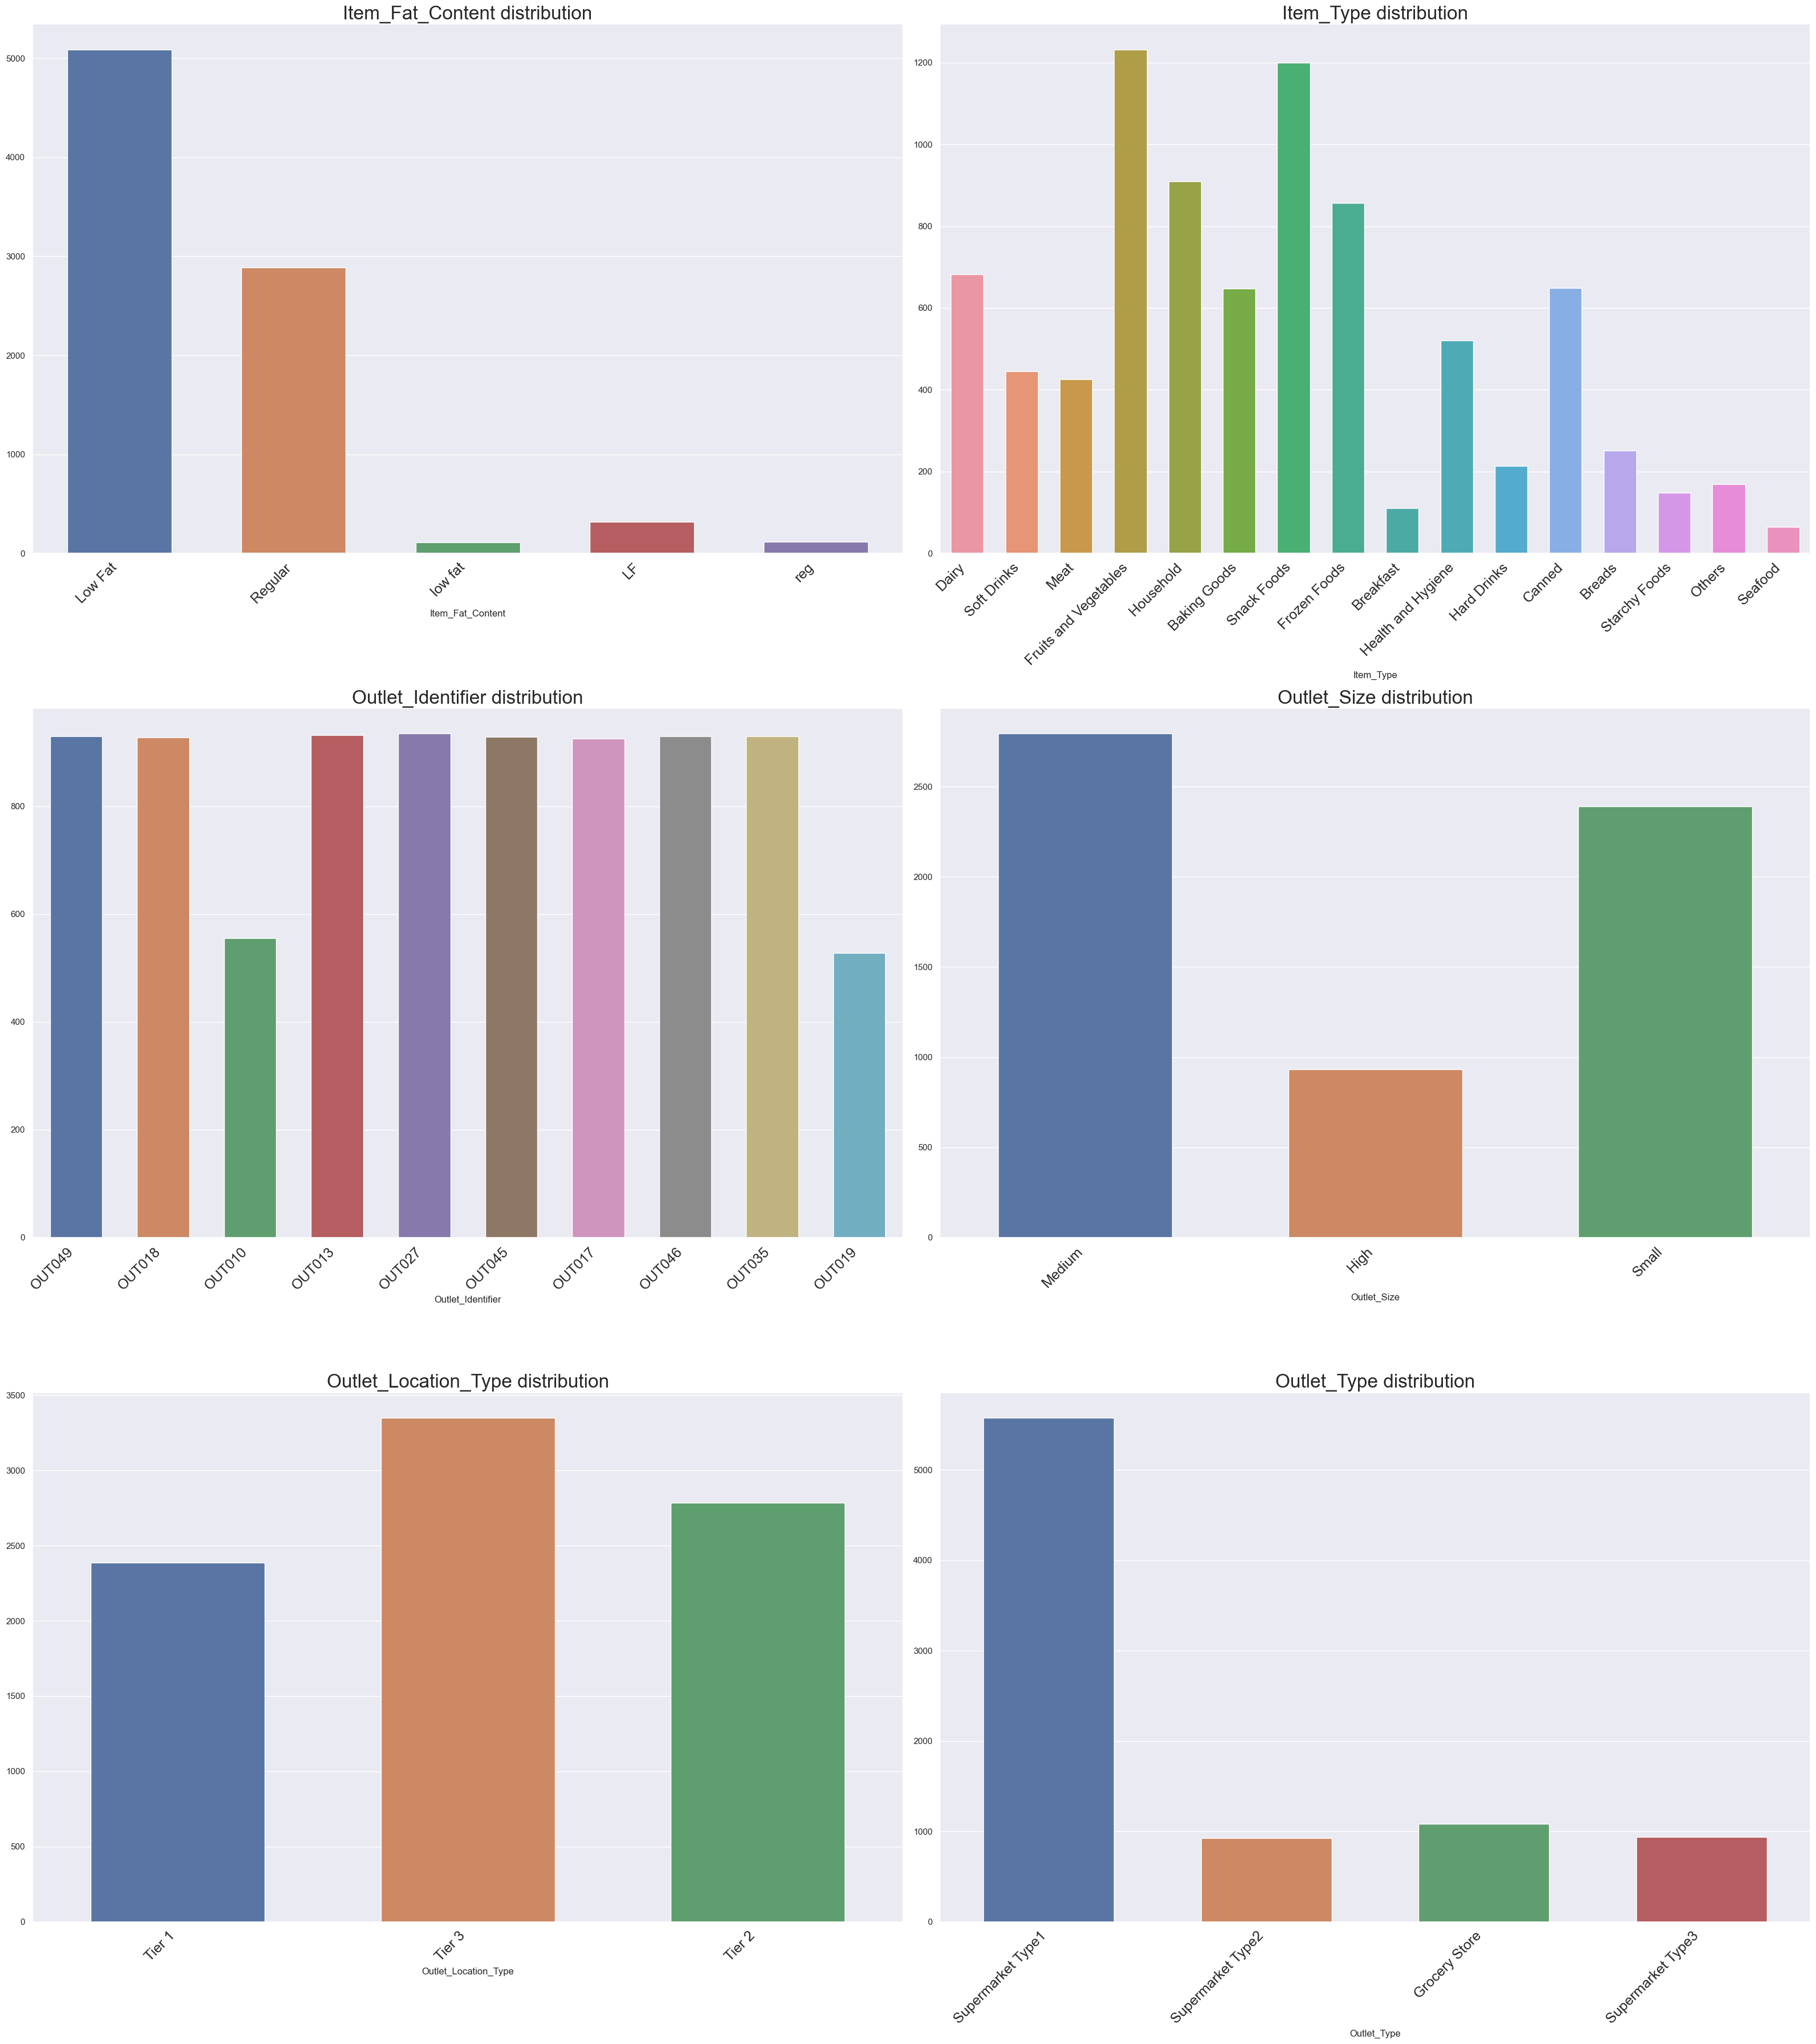

In [54]:
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(32, 36))

for index, col in enumerate(cat_list):
    r = index // 2
    c = index % 2
    g = sns.countplot(data=data, x=col , ax=ax[r][c], width=0.6)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right", fontsize=18)
    ax[r][c].set_title(f'{col} distribution', fontsize=24)
    ax[r][c].set_ylabel('')
    plt.tight_layout()

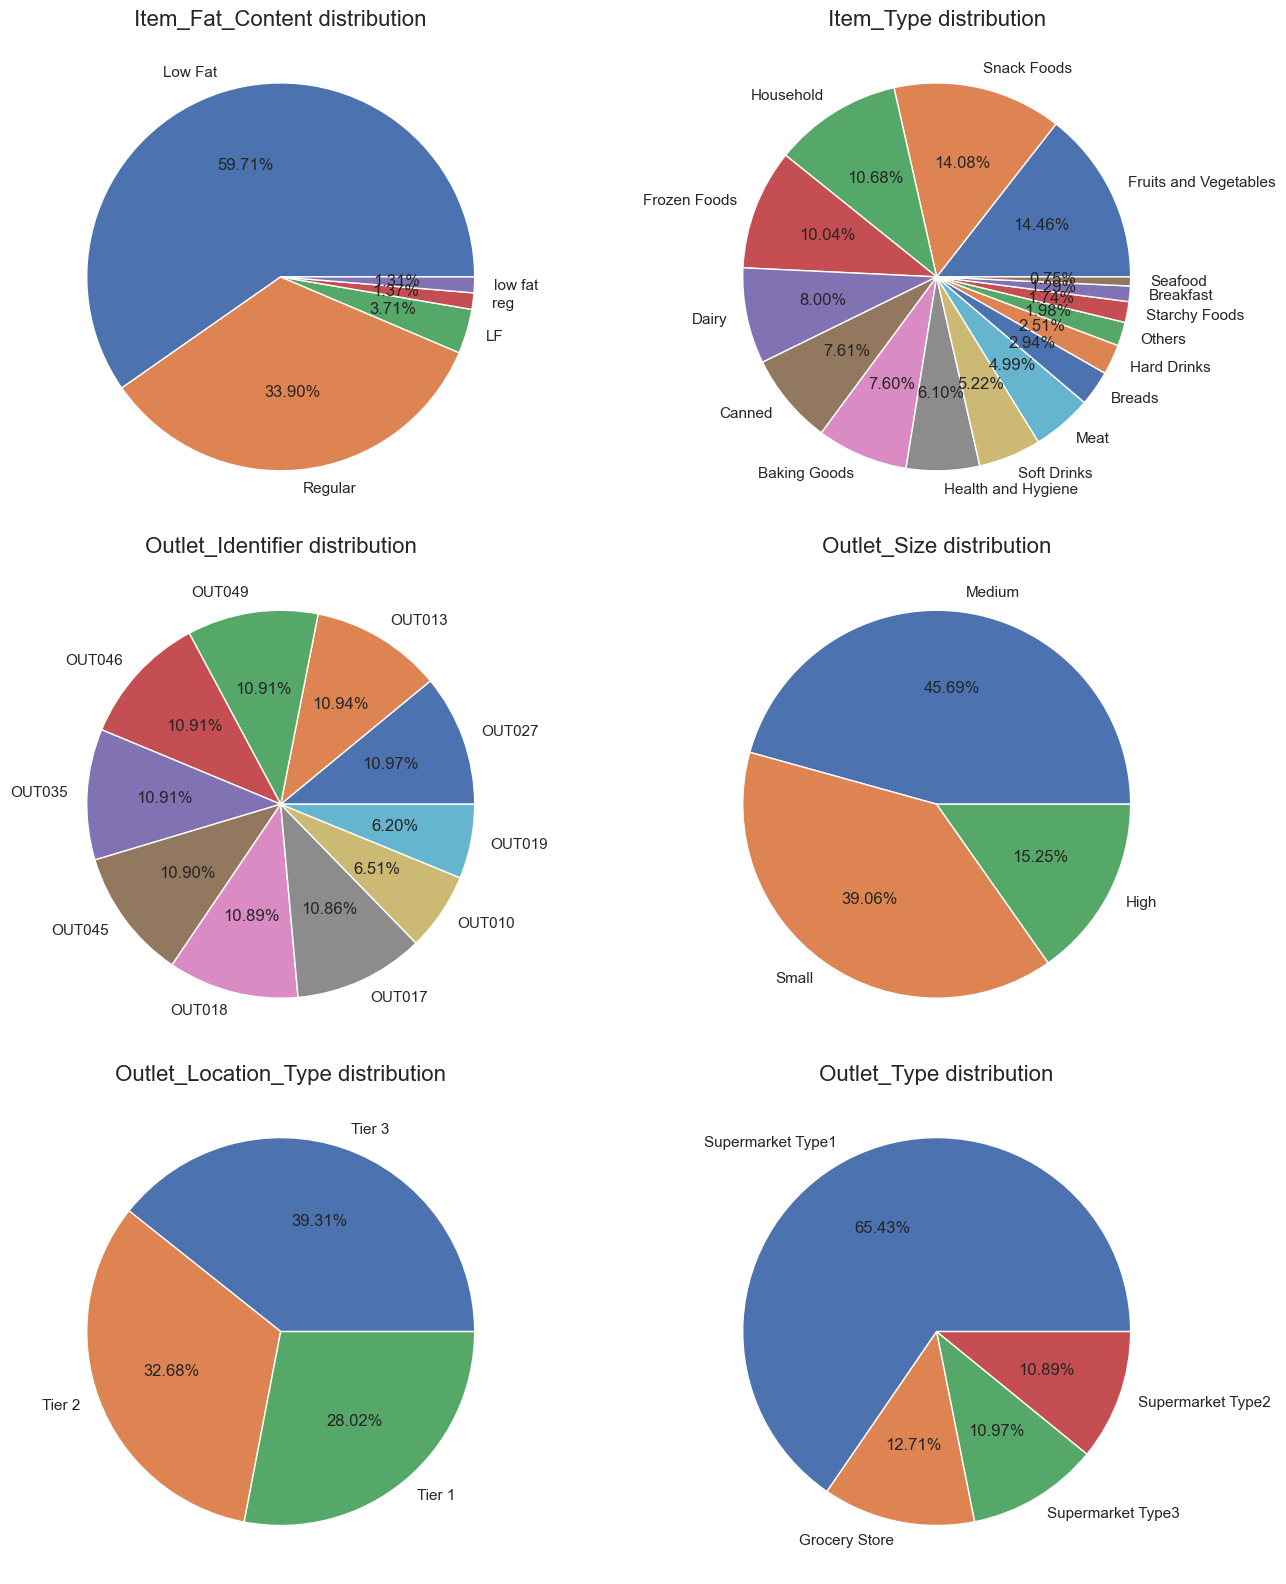

In [63]:
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))

for index, col in enumerate(cat_list):
    r = index // 2
    c = index % 2
    data[col].value_counts().plot(kind="pie", autopct="%.2f%%", ax=ax[r][c])
    ax[r][c].set_title(f'{col} distribution', fontsize=16)
    ax[r][c].set_ylabel('')
    plt.tight_layout()

**Observations:**

* The **Item_Fat_Content** column must be cleaned because there are some entry errors:
    * `Low Fat`, `low fat` and `LF` should be the same category
    * Similarly `Regular` and `reg` should the same
* There are 16 different categories in the the **Item_type** feature. I think it's a lot. May be in the feature engineering section we can try to group them into categories. For example grouping:
    * `Soft Drinks` and `Hard Drinks` into a `Drinks` category.
    * `Snack Foods`, `Frozen Foods`, `Snarchy Foods` and `Seafood` into a `Foods` category.

### Bivariate analysis

Now, I will compare the target variable with the rest to identify possible correlations:

#### Numerical - Numerical

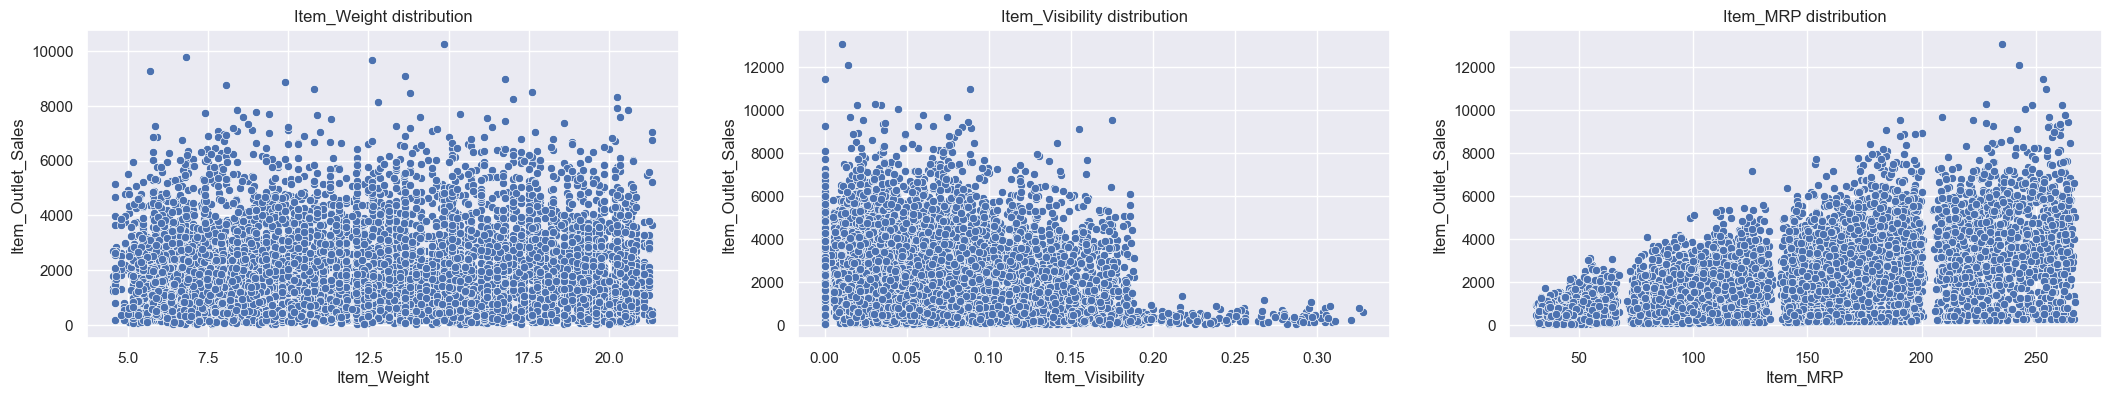

In [64]:
target = 'Item_Outlet_Sales'

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(26, 4))

for index, col in enumerate(['Item_Weight', 'Item_Visibility', 'Item_MRP']):
    sns.scatterplot(data=data, x=col, y=target, ax=ax[index])
    ax[index].set_title(f'{col} distribution')

<Axes: >

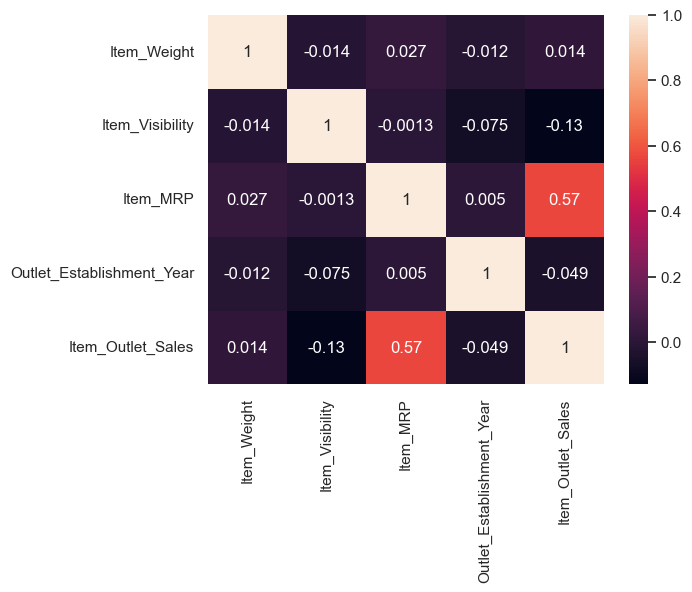

In [66]:
sns.heatmap(data[num_list].corr(), annot=True)

According the heatmap and the plot, the only variable that shows a strong correlation with the sales is the `Item_MRP` variable. 

#### Numerical - Categorical

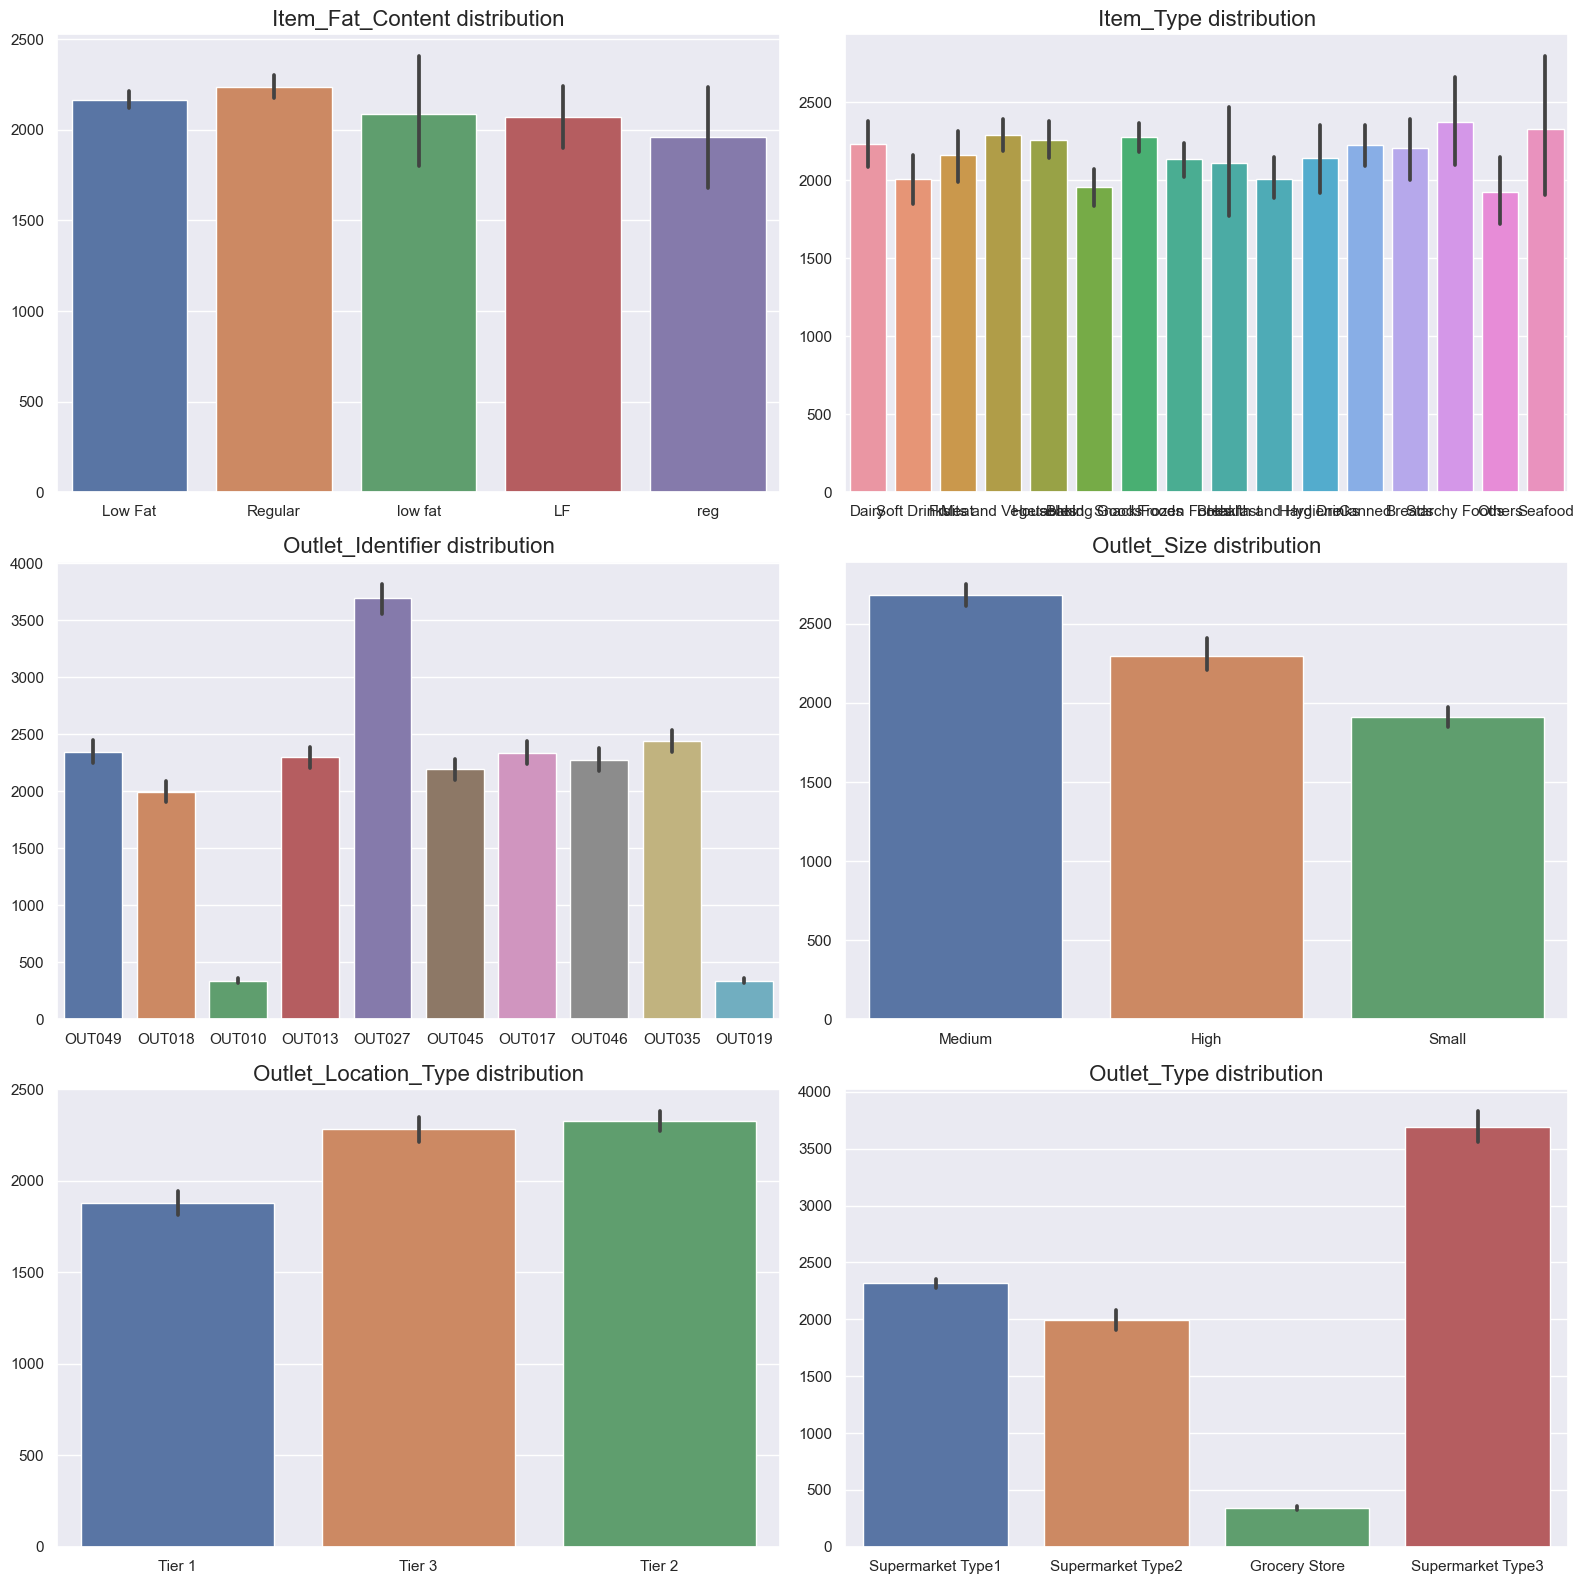

In [68]:
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))

for index, col in enumerate(cat_list):
    r = index // 2
    c = index % 2
    sns.barplot(data=data, x=col, y=target, ax=ax[r][c])
    ax[r][c].set_title(f'{col} distribution', fontsize=16)
    ax[r][c].set_ylabel('')
    ax[r][c].set_xlabel('')
    plt.tight_layout()

**Observations:** 
* **Outlet_Type** seems to be more related with the target than the rest of the variables, being `Supermarket Type 3` the class with higher sales.
* In the **Outlet_Identifier** feature, the outlet `OUT027` is the one with the highest sales, with great difference from the rest.
* **Outlet_Size** and **Outlet_Location** show similar results, being the middle value (`Medium` and `Tier 2`) the one with highest sales, followed by the bigger (`Higher` and `Tier 3`), and finally the smaller one.
* The other two variables, **Item_Fat_Content** and **Item_Type** don't present any meaningful difference between its classes.

## Data Cleaning

In this section I'm going to take care of the following sections:
* Missing values
* Inconsistencies
* Outliers

### Handling Missing Values

##### Item Weight

Let's start with the **Item_Weight**. To impute missing values, I will calculate the mean value of each class and impute that value.

In [27]:
mean_weights = data.groupby(['Item_Type'])['Item_Weight'].mean().reset_index()
mean_weights.rename(columns={'Item_Weight': 'Mean_Item_Weight'}, inplace=True)
mean_weights

,Item_Type,Mean_Item_Weight
0,Baking Goods,12.277108
1,Breads,11.346936
2,Breakfast,12.768202
3,Canned,12.305705
4,Dairy,13.426069
5,Frozen Foods,12.867061
6,Fruits and Vegetables,13.224769
7,Hard Drinks,11.400328
8,Health and Hygiene,13.142314
9,Household,13.384736


In [29]:
# Merge the two datasets to impute the values
data_without_nulls = data.merge(mean_weights, on=['Item_Type'], how='left')
# Impute null values
data_without_nulls['Item_Weight'] = data_without_nulls['Item_Weight'].fillna(data_without_nulls['Mean_Item_Weight'])
# Drop the column used for imputing
data_without_nulls.drop(columns='Mean_Item_Weight', inplace=True)

data_without_nulls.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

##### Outlet Size

For the outlet size, I am going to use the mode of each outlet type.

In [32]:
outlet_sizes_by_type = data.groupby('Outlet_Type')['Outlet_Size'].apply(lambda x: x.mode().iloc[0]).reset_index()
outlet_sizes_by_type.rename(columns={'Outlet_Size': 'Outlet_Size_Mode'}, inplace=True)
outlet_sizes_by_type

,Outlet_Type,Outlet_Size_Mode
0,Grocery Store,Small
1,Supermarket Type1,Small
2,Supermarket Type2,Medium
3,Supermarket Type3,Medium


In [33]:
# Merge the two datasets to impute the values
data_without_nulls = data_without_nulls.merge(outlet_sizes_by_type, on=['Outlet_Type'], how='left')
# Impute null values
data_without_nulls['Outlet_Size'] = data_without_nulls['Outlet_Size'].fillna(data_without_nulls['Outlet_Size_Mode'])
# Drop the column used for imputing
data_without_nulls.drop(columns='Outlet_Size_Mode', inplace=True)

data_without_nulls.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

### Inconsistencies

In this part I will simply correct the inconsistencies seen in the **Item_Fat_Content** column.

In [98]:
data_without_nulls['Item_Fat_Content'] = data_without_nulls['Item_Fat_Content'].str.replace('low fat', 'Low Fat').replace('LF', 'Low Fat').replace('reg', 'Regular')
data_without_nulls['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

#### Outliers

I'll check the outliers using the IQR on the **Item_Outlet_Sales** and **Item_Visibility** variables. 

In [80]:
def outliers_iqr(df, column):
    # Calculate the first and third quartiles
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return upper_bound # I only return the upper bound since the lower one does not have sense in this context

In [81]:
sales_upper_bound = outliers_iqr(data, 'Item_Outlet_Sales')

print("Sales upper bound {}".format(sales_upper_bound))

Sales upper bound 6501.8699


<Axes: xlabel='Item_Outlet_Sales', ylabel='Count'>

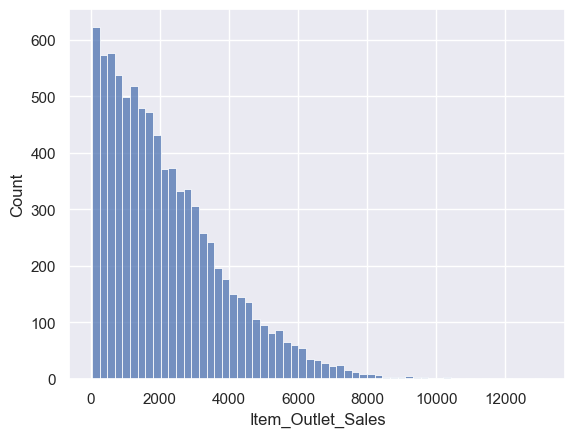

In [79]:
sns.histplot(data['Item_Outlet_Sales'])

Looking at the distribution, it does not seem that from the upper bound returned by the function we see a change in the pattern, I will consider 8000 as the upper bound instead and remove the values greater than that one. 

In [82]:
visibility_upper_bound = outliers_iqr(data, 'Item_Visibility')

print("Visibility upper bound {}".format(visibility_upper_bound))

Visibility upper bound 0.195979015


<Axes: xlabel='Item_Visibility', ylabel='Count'>

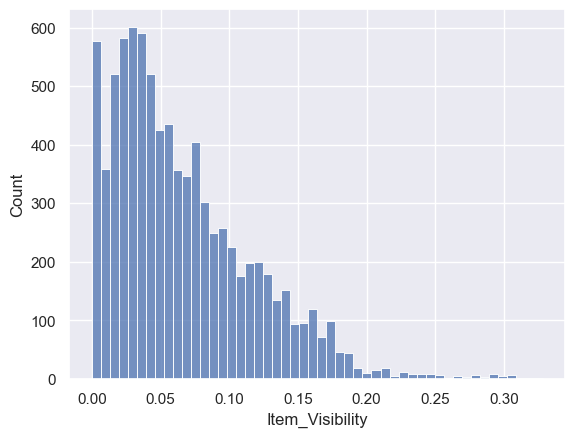

In [83]:
sns.histplot(data['Item_Visibility'])

In this case, it does seem that from the upper value we have a different distribution, so I'll be considering this as the upper bound for the outliers.

In [99]:
data_without_ouliers = data_without_nulls[(data_without_nulls['Item_Visibility'] < visibility_upper_bound) & (data_without_nulls['Item_Outlet_Sales'] < 8000)]
data_without_ouliers.shape

(8329, 12)

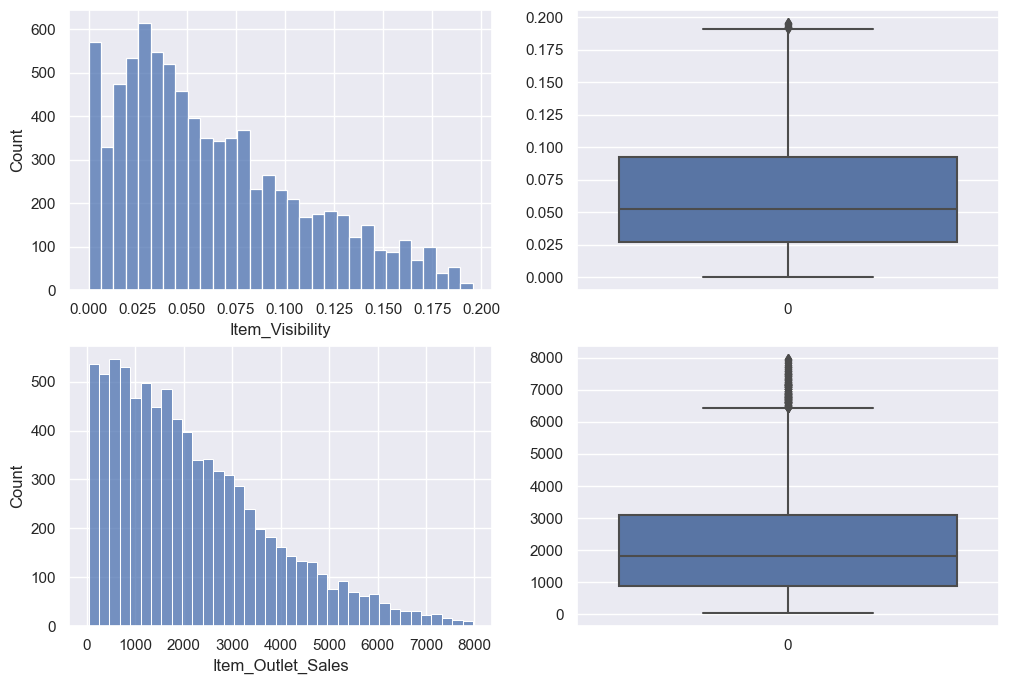

In [94]:
_, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for index, col in enumerate(['Item_Visibility', 'Item_Outlet_Sales']):
    sns.histplot(data_without_ouliers[col], ax=ax[index][0])
    sns.boxplot(data_without_ouliers[col], ax=ax[index][1])

## Feature Engineering

In this step I will calculate the years of each outlet using the `Outlet_Establishment_Year`. Since the data was collected in 2013 I will use this year as the reference to calculate the measure:

In [100]:
data_without_ouliers['Outlet_Years'] = 2013 - data_without_ouliers['Outlet_Establishment_Year']
data_without_ouliers.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Years
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,14
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,4
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,14
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,15
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,26


In [101]:
data_without_ouliers.drop('Outlet_Establishment_Year', axis = 1, inplace = True)

I will also calculate a new column using the `Item_Identifier` column. I will keep the first two letters of the column, creating the following classes:
* `FD` for Food
* `DR` for Drinks
* `NC` for Non-consumables

In [130]:
data_without_ouliers['Item_Family'] = data_without_ouliers['Item_Identifier'].str[:2]
data_without_ouliers.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Years,Item_Family
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,14,FD
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,4,DR
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,14,FD
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,Small,Tier 3,Grocery Store,732.3800,15,FD
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,26,NC


In [131]:
data_clean = data_without_ouliers.copy()
data_clean.to_csv("train_data_clean.csv", index=False)

In [189]:
data_clean = pd.read_csv("train_data_clean.csv")

## Preprocessing

First of all I will drop the `Item_Identifier` column:

In [190]:
data_clean.drop('Item_Identifier', axis = 1, inplace = True)

### Label encoding

I will encode the variables `Item_Family`, `Item_Fat_Content`, `Outlet_Size`, `Outlet_Location_Type` and `Outlet_Type`:

In [191]:
to_encode = ['Item_Family', 'Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

le = LabelEncoder()

for col in to_encode:
    data_clean[col] = le.fit_transform(data_clean[col])

In [192]:
data_clean.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Years,Item_Family
0,9.30,0,0.016047,Dairy,249.8092,OUT049,1,0,1,3735.1380,14,1
1,5.92,1,0.019278,Soft Drinks,48.2692,OUT018,1,2,2,443.4228,4,0
2,17.50,0,0.016760,Meat,141.6180,OUT049,1,0,1,2097.2700,14,1
3,19.20,1,0.000000,Fruits and Vegetables,182.0950,OUT010,2,2,0,732.3800,15,1
4,8.93,0,0.000000,Household,53.8614,OUT013,0,2,1,994.7052,26,2


### Dummy variables

For the rest of the categorical variables I'll create dummy variables:

In [193]:
to_dummy = ['Item_Type', 'Outlet_Identifier']

data_clean = pd.get_dummies(data_clean, columns = to_dummy, drop_first=True, dtype = 'int')

data_clean.shape

(8329, 34)

In [194]:
data_clean.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Years,Item_Family,...,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,9.30,0,0.016047,249.8092,1,0,1,3735.1380,14,1,...,0,0,0,0,0,0,0,0,0,1
1,5.92,1,0.019278,48.2692,1,2,2,443.4228,4,0,...,0,0,0,1,0,0,0,0,0,0
2,17.50,0,0.016760,141.6180,1,0,1,2097.2700,14,1,...,0,0,0,0,0,0,0,0,0,1
3,19.20,1,0.000000,182.0950,2,2,0,732.3800,15,1,...,0,0,0,0,0,0,0,0,0,0
4,8.93,0,0.000000,53.8614,0,2,1,994.7052,26,2,...,0,1,0,0,0,0,0,0,0,0


### Split into training and testing sets

In [195]:
features = data_clean.columns.tolist()
features.remove('Item_Outlet_Sales')

In [196]:
X_train, X_test, y_train, y_test = train_test_split(data_clean[features], data_clean['Item_Outlet_Sales'], test_size=0.25, random_state=0)

### Feature Scaling

In [152]:
#sc = StandardScaler()

#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

## Modeling

### Linear Regression

In [197]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [198]:
lr_preds = lr.predict(X_test)

In [199]:
print('Training score  : {}'.format(lr.score(X_train, y_train)))
print('Test score      : {}'.format(lr.score(X_test, y_test)))

Training score  : 0.5574075857058087
Test score      : 0.554515464755877


In [200]:
# Evaluation
lr_mse  = mean_squared_error(y_test , lr_preds)
lr_rmse = math.sqrt(lr_mse)
lr_r2   = r2_score(y_test, lr_preds)

print('RMSE  \t         ----> {}'.format(lr_rmse))
print('R2 Score         ----> {}'.format(lr_r2))

RMSE  	         ----> 1072.2764642455327
R2 Score         ----> 0.554515464755877


In [203]:
steps = [
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LinearRegression())
]

pol_reg = Pipeline(steps)

pol_reg.fit(X_train, y_train)

print('Training score  : {}'.format(pol_reg.score(X_train, y_train)))
print('Test score      : {}'.format(pol_reg.score(X_test, y_test)))

Training score  : 0.6089523807645945
Test score      : 0.5716161672216535


In [205]:
pol_reg_preds = pol_reg.predict(X_test)
# Evaluation
pol_reg_mse  = mean_squared_error(y_test , pol_reg_preds)
pol_reg_rmse = math.sqrt(pol_reg_mse)
pol_reg_r2   = r2_score(y_test, pol_reg_preds)

print('RMSE  \t         ----> {}'.format(pol_reg_rmse))
print('R2 Score         ----> {}'.format(pol_reg_r2))

RMSE  	         ----> 1051.4944713207453
R2 Score         ----> 0.5716161672216535


### Ridge and Lasso Regressions

#### Ridge

In [206]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

In [213]:
steps = [
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('ridge', RidgeCV(alphas=np.arange(0.1, 10, 0.1), cv=cv, scoring='neg_mean_squared_error'))
]

ridge_pol = Pipeline(steps)

ridge_pol.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('poly', PolynomialFeatures()),
                ('ridge',
                 RidgeCV(alphas=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]),
                         cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=1),
                         scoring='neg_mean_squared_error'))])

In [215]:
print('Training score  : {}'.format(ridge_pol.score(X_train, y_train)))
print('Test score      : {}'.format(ridge_pol.score(X_test, y_test)))

Training score  : 0.6089478984572314
Test score      : 0.5717271621536266


In [216]:
ridge_pol_preds = ridge_pol.predict(X_test)

In [219]:
# Evaluation
ridge_pol_mse  = mean_squared_error(y_test , ridge_pol_preds)
ridge_pol_rmse = math.sqrt(ridge_pol_mse)
ridge_pol_r2   = r2_score(y_test, ridge_pol_preds)

print('RMSE  \t         ----> {}'.format(ridge_pol_rmse))
print('R2 Score         ----> {}'.format(ridge_pol_r2))

RMSE  	         ----> 1051.3582405513562
R2 Score         ----> 0.5717271621536266


#### Lasso

In [220]:
steps = [
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('lasso', LassoCV(alphas=np.arange(0.1, 10, 0.1), cv=cv, tol=1))
]

lasso = LassoCV(alphas=np.arange(0.1, 10, 0.1), cv=cv, tol=1)
lasso_pol = Pipeline(steps)

In [221]:
lasso.fit(X_train, y_train)
lasso_pol.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('poly', PolynomialFeatures()),
                ('lasso',
                 LassoCV(alphas=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]),
                         cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=1),
                         tol=1))])

In [222]:
lasso_preds = lasso.predict(X_test)
lasso_pol_preds = lasso_pol.predict(X_test)

In [224]:
print("Lasso")
print('Training score  : {}'.format(lasso.score(X_train, y_train)))
print('Test score      : {}'.format(lasso.score(X_test, y_test)))
print()
print("Polinomial Lasso")
print('Training score  : {}'.format(lasso_pol.score(X_train, y_train)))
print('Test score      : {}'.format(lasso_pol.score(X_test, y_test)))

Lasso
Training score  : 0.5530116020814702
Test score      : 0.554736673500754

Polinomial Lasso
Training score  : 0.6000732753633232
Test score      : 0.5809352302768198


In [226]:
# Evaluation
lasso_mse  = mean_squared_error(y_test , lasso_preds)
lasso_rmse = math.sqrt(lasso_mse)
lasso_r2   = r2_score(y_test, lasso_preds)
print("Lasso")
print('RMSE  \t         ----> {}'.format(lasso_rmse))
print('R2 Score         ----> {}'.format(lasso_r2))

print()
lasso_pol_mse  = mean_squared_error(y_test , lasso_pol_preds)
lasso_pol_rmse = math.sqrt(lasso_pol_mse)
lasso_pol_r2   = r2_score(y_test, lasso_pol_preds)
print("Lasso polynomial")
print('RMSE  \t         ----> {}'.format(lasso_pol_rmse))
print('R2 Score         ----> {}'.format(lasso_pol_r2))

Lasso
RMSE  	         ----> 1072.0102076587734
R2 Score         ----> 0.554736673500754

Lasso polynomial
RMSE  	         ----> 1039.9944779250905
R2 Score         ----> 0.5809352302768198


### Support Vector Machines (SVM)

#### Linear Kernel

In [229]:
steps = [
    ('scaler', StandardScaler()),
    ('svm_linear', SVR(kernel = 'linear'))
]

svm_l = Pipeline(steps)

# Train the regressor
svm_l.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_linear', SVR(kernel='linear'))])

In [230]:
print('Training score  : {}'.format(svm_l.score(X_train, y_train)))
print('Test score      : {}'.format(svm_l.score(X_test, y_test)))

Training score  : 0.5153686588817699
Test score      : 0.5036396704263253


#### Rbf kernel

In [231]:
steps = [
    ('scaler', StandardScaler()),
    ('svm_rbf', SVR(kernel = 'rbf'))
]

svm_r = Pipeline(steps)

# Train the regressor
svm_r.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svm_rbf', SVR())])

In [232]:
print('Training score  : {}'.format(svm_r.score(X_train, y_train)))
print('Test score      : {}'.format(svm_r.score(X_test, y_test)))

Training score  : -0.0014139342375507624
Test score      : -0.009260006077450589


### Decision Tree Regressor

In [248]:
dt = DecisionTreeRegressor(random_state = 0, ccp_alpha=0.4) 

dt.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.4, random_state=0)

In [249]:
print('Training score  : {}'.format(dt.score(X_train, y_train)))
print('Test score      : {}'.format(dt.score(X_test, y_test)))

Training score  : 0.9999702011436384
Test score      : 0.1540974044934168


In [250]:
dt_preds = dt.predict(X_test)

dt_mse  = mean_squared_error(y_test , dt_preds)
dt_rmse = math.sqrt(dt_mse)
dt_r2   = r2_score(y_test, dt_preds)

print('RMSE  \t         ----> {}'.format(dt_rmse))
print('R2 Score         ----> {}'.format(dt_r2))

RMSE  	         ----> 1477.5787486347563
R2 Score         ----> 0.1540974044934168


### Random Forest Regression

In [257]:
rf = RandomForestRegressor(n_estimators=25, random_state=0, max_depth=15)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=25, random_state=0)

In [258]:
print('Training score  : {}'.format(rf.score(X_train, y_train)))
print('Test score      : {}'.format(rf.score(X_test, y_test)))

Training score  : 0.8377659733585958
Test score      : 0.5588313644586375


### XGBoost

In [276]:
xgb = XGBRegressor(max_depth = 4, reg_lambda = 100)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [277]:
xgb_preds = xgb.predict(X_test)

In [278]:
print('Training score  : {}'.format(xgb.score(X_train, y_train)))
print('Test score      : {}'.format(xgb.score(X_test, y_test)))

Training score  : 0.6609013137678967
Test score      : 0.5735152141993249


In [296]:
parameters = [
    {
        'learning_rate': [0.01, 0.1, 0.2], # default 0.3
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.2],
        'max_depth': [5,4,3], # default 6
        'reg_lambda': [10, 100, 200, 250, 500] # default 1
    }
]

xgb_reg = XGBRegressor()
random_search = RandomizedSearchCV(estimator = xgb_reg,
                                 param_distributions = parameters,
                                 n_iter = 10,
                                 scoring = "neg_mean_squared_error",
                                 cv = 5,
                                 verbose = 1,
                                 n_jobs = -1,
                                 random_state=42
                               )

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_jobs=-1,
                   param_distributions=[{'colsample_bytree': [0.8, 0.9, 1.0],
                                         'gamma': [0, 0.1, 0.2],
                                         'learning_rate': [0.01, 0.1, 0.2],
                                         'max_depth': [5, 4, 3],
                                         'min_child_weight': [1, 3, 5],
                                         'n_estimators': [100, 200, 300],
                                         'reg_lambda': [10, 100, 200, 250, 500],
                                         'subsample': [0.8, 0.9, 1.0]}],
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [297]:
best_params = random_search.best_params_

In [298]:
print(best_params)

{'subsample': 0.9, 'reg_lambda': 500, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.9}


In [299]:
xgb_regressor = XGBRegressor(**best_params)

In [300]:
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [309]:
xgb_preds = xgb_regressor.predict(X_test)

print('Training score  : {}'.format(xgb_regressor.score(X_train, y_train)))
print('Test score      : {}'.format(xgb_regressor.score(X_test, y_test)))

xgb_mse  = mean_squared_error(y_test , xgb_preds)
xgb_rmse = math.sqrt(xgb_mse)
xgb_r2   = r2_score(y_test, xgb_preds)

print()
print('RMSE  \t         ----> {}'.format(xgb_rmse))
print('R2 Score         ----> {}'.format(xgb_r2))

Training score  : 0.6174158837261541
Test score      : 0.5876450215577231

RMSE  	         ----> 1031.6350253474652
R2 Score         ----> 0.5876450215577231


In [310]:
xgb_reg = XGBRegressor(learning_rate=0.1, max_depth=3, reg_lambda=600, n_estimators=300, gamma=0.1)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [311]:
xgb_preds = xgb_reg.predict(X_test)

print('Training score  : {}'.format(xgb_reg.score(X_train, y_train)))
print('Test score      : {}'.format(xgb_reg.score(X_test, y_test)))

xgb_mse  = mean_squared_error(y_test , xgb_preds)
xgb_rmse = math.sqrt(xgb_mse)
xgb_r2   = r2_score(y_test, xgb_preds)

print()
print('RMSE  \t         ----> {}'.format(xgb_rmse))
print('R2 Score         ----> {}'.format(xgb_r2))

Training score  : 0.6124196958068557
Test score      : 0.5864163478701709

RMSE  	         ----> 1033.1708380240316
R2 Score         ----> 0.5864163478701709


In [285]:
print('Training score  : {}'.format(xgb_reg.score(X_train, y_train)))
print('Test score      : {}'.format(xgb_reg.score(X_test, y_test)))

Training score  : 0.6150905833512272
Test score      : 0.587068469815498
